In [39]:
# Source: https://github.com/RubensZimbres/Repo-2022/blob/main/Cellular-Automaton/Cellular_automaton_toroid.py
import os
import sys
from pathlib import Path
sys.path.append(str(Path(os.getcwd()).parent))
import itertools
from functools import partial

import torch
from torch import tensor,nn,optim
import torchvision.transforms.functional as TF,torch.nn.functional as F
import torchvision
from torcheval.metrics import MulticlassAccuracy
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from fastcore.foundation import L, store_attr
import fastcore.all as fc
from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *


## Data

In [2]:
## Data
device = torch.device("cuda")

batch_size1=1000

def get_dl(path, train=True, batch_size1=1000):
    dl=torch.utils.data.DataLoader(
          torchvision.datasets.MNIST(path, train=train, download=True,
                                     transform=torchvision.transforms.Compose([
                                         torchvision.transforms.ToTensor(),
                                         torchvision.transforms.Normalize(
                                             (0.0,), (1.,))
                                     ])),
        batch_size=batch_size1, shuffle=True)
    return dl

def get_dls(path, batch_size1=1000):
    return DataLoaders(get_dl(path, train=True, batch_size1=batch_size1),
                      get_dl(path, train=False, batch_size1=batch_size1))

In [3]:
data_path='data/mnist/'
dls=get_dls(data_path)

In [4]:
len(dls.train)

60

## Kernel

In [5]:
## kernel
regra=2159062512564987644819455219116893945895958528152021228705752563807959237655911950549124
base1=5
states=np.arange(0,base1)
dimensions=5

## KERNEL 5x5

kernel=[[1, 0, 1, 0, 1],
       [0, 1, 0, 1, 0],
       [0, 0, 1, 0, 0],
       [0, 1, 0, 1, 0],
       [1, 0, 1, 0, 1]]

## Model

In [6]:
def cellular_automaton():
    global kernel

    lista=states
    kernel=np.pad(kernel, (1, 1), 'constant', constant_values=(0))
    kernel[0]=kernel[1]
    kernel[-1]=kernel[-2]

    kernel2=np.transpose(kernel)
    kernel2[0]=kernel2[1]
    kernel2[-1]=kernel2[-2]

    kernel=np.transpose(kernel2)

    all_possible_states=np.array([p for p in itertools.product(lista, repeat=3)])[::-1]

    zeros_all_possible_states = np.zeros(all_possible_states.shape[0])
    final_states = [int(i) for i in np.base_repr(int(regra),base=base1)]
    zeros_all_possible_states[-len(final_states):]=final_states
    length_rules=np.array(range(0,len(zeros_all_possible_states)))

    final_state_central_cell=[]
    for i in range(0,len(zeros_all_possible_states)):
        final_state_central_cell.append([0,int(zeros_all_possible_states[i]),0])

    initial_and_final_states=[]
    for i in range(0,len(all_possible_states)):
        initial_and_final_states.append(np.array([all_possible_states[i],np.array(final_state_central_cell).astype(np.int8)[i]]))

    def ca(row):
        out=[]
        for cell in range(0,dimensions):
            out.append(final_state_central_cell[next((i for i, val in enumerate(all_possible_states) if np.all(val == kernel[row][cell:cell+3])), -1)][1])
        return out

    kernel=np.array([item for item in map(ca,range(1,kernel.shape[0]-1))])
    return kernel



In [7]:
class Net(nn.Module):
    def __init__(self, kernel):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(32, 64, 3, 1,bias=False)
        self.conv2 = nn.Conv2d(1, 64, 10, 1,bias=False)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.4)
        self.fc1 = nn.Linear(3136, 28*28)
        self.fc2 = nn.Linear(28*28, 128)
        self.fc3 = nn.Linear(128, 10)
        torch.nn.init.xavier_uniform(self.conv1.weight)
        torch.nn.init.xavier_uniform(self.conv2.weight)
        torch.nn.init.xavier_uniform(self.fc1.weight)
        torch.nn.init.xavier_uniform(self.fc2.weight)
        torch.nn.init.xavier_uniform(self.fc3.weight)
        self.batch_norm = nn.BatchNorm1d(3136)
        self.conv1.weight = nn.Parameter(kernel,requires_grad=False)


    def forward(self, x):
        res = x.view(batch_size1, 784)
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = nn.MaxPool2d(2, 2)(x)
        x = F.relu(x)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.batch_norm(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(torch.mean(torch.stack((x,res)),0))
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)
        return output

In [8]:
class NCAProgressCB(ProgressCB):
    def after_batch(self, learn):
        learn.dl.comment = f'{learn.loss:.3f}'
        if not (hasattr(learn, 'metrics') and learn.training): return 
        self.losses.append(learn.loss.item())
        mbar = self.mbar
        if not hasattr(mbar, 'graph_fig'):
            mbar.graph_fig, mbar.graph_axs = plt.subplots(1, 1, figsize=(12, 3.5))
            mbar.graph_out = display(mbar.graph_fig, display_id=True)

        # Update preview image every 64 iters
        if (len(self.losses))%64 != 10: return 
        
        # Plot losses:
        mbar.graph_axs.clear()
        mbar.graph_axs.plot(self.losses, '.', alpha=0.3)
        mbar.graph_axs.set_yscale('log')
        mbar.graph_axs.set_ylim(tensor(self.losses).min(), self.losses[0])
        
        # Update graph
        mbar.graph_out.update(mbar.graph_fig)

In [9]:
class NCACB(TrainCB):
    order = DeviceCB.order+1
    def __init__(self, model, n_inp=-1, batch_size=4):
        fc.store_attr()
            
    def backward(self, learn):
        learn.loss.backward()
        
    def before_fit(self, learn): self.learn=learn 
    
def norm(x):
    return (x-x.min())/(x.max()-x.min())

In [10]:
learning_rate=0.001

c=torch.from_numpy(norm(cellular_automaton()).astype(np.float16).reshape(-1,1,dimensions,dimensions)).type(torch.cuda.FloatTensor)
model = Net(c).to(device)

opt_func = partial(optim.AdamW, eps=1e-5)
#opt_func=partial(optim.SGD, momentum=0.6)
#lr_scheduler=partial(torch.optim.lr_scheduler.CosineAnnealingLR, T_max=learning_rate, eta_min=learning_rate/10, 
   #                 last_epoch=- 1)
#sched_cb = [BatchSchedCB(lr_scheduler)]

cbs = [NCACB(model, batch_size=batch_size1), DeviceCB(), NCAProgressCB(), MetricsCB(accuracy=MulticlassAccuracy())]
learn = Learner(model, get_dls(data_path),  F.cross_entropy, lr=learning_rate, cbs=cbs, opt_func=opt_func)

/tmp/ipykernel_460/2741792141.py:11: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.conv1.weight)
/tmp/ipykernel_460/2741792141.py:12: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.conv2.weight)
/tmp/ipykernel_460/2741792141.py:13: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)
/tmp/ipykernel_460/2741792141.py:14: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc2.weight)
/tmp/ipykernel_460/2741792141.py:15: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc3.weight)


accuracy,loss,epoch,train
0.913,0.280,0,train
0.978,0.072,0,eval
0.973,0.088,1,train
0.983,0.057,1,eval
0.981,0.061,2,train
0.982,0.060,2,eval
0.984,0.051,3,train
0.985,0.044,3,eval
0.987,0.042,4,train
0.985,0.048,4,eval


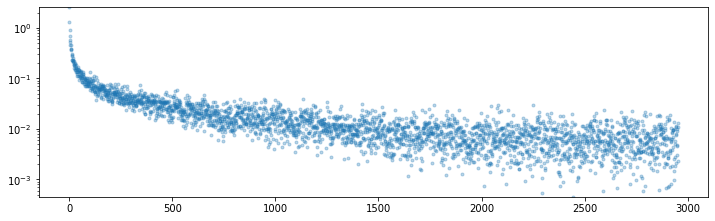

In [11]:
learn.fit(50)

accuracy,loss,epoch,train
0.999,0.004,0,train
0.991,0.044,0,eval
0.999,0.002,1,train
0.992,0.044,1,eval
1.000,0.001,2,train
0.992,0.045,2,eval
1.000,0.002,3,train
0.992,0.045,3,eval
1.000,0.001,4,train
0.992,0.044,4,eval


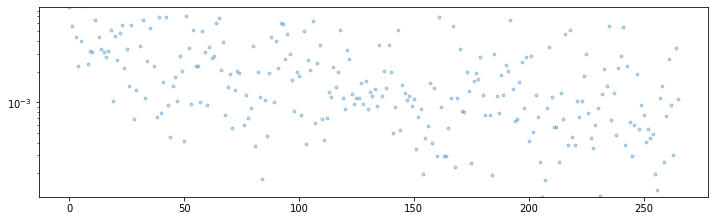

In [13]:
learn.fit(5, lr=0.0001)

accuracy,loss,epoch,train
1.000,0.001,0,train
0.992,0.044,0,eval
1.000,0.001,1,train
0.992,0.044,1,eval
1.000,0.001,2,train
0.992,0.045,2,eval
1.000,0.001,3,train
0.992,0.045,3,eval
1.000,0.001,4,train
0.992,0.045,4,eval


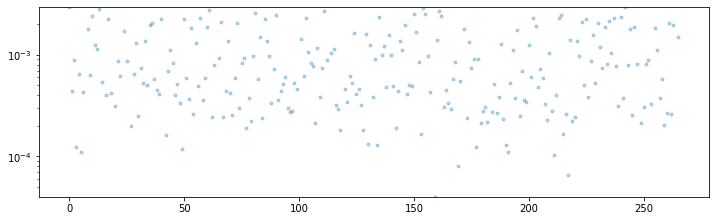

In [14]:
learn.fit(5, lr=0.00001)

## Test model

In [22]:
b=next(iter(learn.dls.valid))
preds=learn.model(b[0].to('cuda'))

In [26]:
preds.argmax(dim=1).shape

torch.Size([1000])

In [33]:
preds_all=[]
reals_all=[]
for b in learn.dls.valid:
    preds=learn.model(b[0].to('cuda'))
    preds_labels=preds.argmax(dim=1)
    preds_all.extend(preds.argmax(dim=1).cpu().numpy().tolist())
    reals_all.extend(b[1].cpu().numpy().tolist())

In [12]:
#number of paramaeters in the model
sum(p.numel() for p in model.parameters())

2573875

In [36]:
df_preds=pd.DataFrame({'real':reals_all, 
                       'preds':preds_all})
df_preds.shape

(10000, 2)

In [38]:
pd.crosstab(df_preds.real, df_preds.preds)

preds,0,1,2,3,4,5,6,7,8,9
real,,,,,,,,,,
0,978,0,0,0,0,0,0,0,1,1
1,0,1133,0,1,0,0,0,0,1,0
2,0,1,1025,2,1,0,0,2,1,0
3,0,0,1,1001,0,4,0,1,2,1
4,0,0,0,0,972,0,4,1,1,4
5,2,1,0,5,0,881,1,1,1,0
6,3,2,0,0,1,1,950,0,1,0
7,0,2,4,1,0,0,0,1017,1,3
8,1,0,1,1,1,0,1,1,967,1


In [41]:
print(classification_report(df_preds.real, df_preds.preds))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       980
           1       0.99      1.00      1.00      1135
           2       0.99      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [42]:
df_preds[df_preds.real==df_preds.preds].shape[0]/df_preds.shape[0]

0.9918